In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
## Environment
# Change main system path to be able to run code from src folder
import sys
p = sys.path[0]
# Mac OS
if sys.path[0].endswith('/models'):
    main_path = p[:-len('/models')]
sys.path[0] = main_path

import os, gc
from termcolor import colored
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from src import (config, fe, features, preprocess, training)
from src.fe import CreateFeatures

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# DATA PREPARATION
# ===== LOAD DATA ======
metadata = pd.read_csv(config.DATA_DIR + 'metadata.csv')
print(f'Metadata: {metadata.shape}')

train_labels = pd.read_csv(config.DATA_DIR + 'train_labels.csv')
print(f'Train labels: {train_labels.shape}')

valid_labels = pd.read_csv(config.DATA_DIR + 'val_labels.csv')
print(f'Train labels: {valid_labels.shape}')

# Combine train and valid labels
trvl_labels = pd.concat([train_labels, valid_labels], axis = 0)

submission = pd.read_csv(config.DATA_DIR + 'submission_format.csv')
print(f'Submission: {submission.shape}')

# ===== FILE PATHS OF SAMPLES =====
train_files = metadata[metadata.split == 'train']['features_path'].to_dict()
valid_files = metadata[metadata.split == 'val']['features_path'].to_dict()
test_files = metadata[metadata.split == 'test']['features_path'].to_dict()
# Train & Valid files
trva_files = train_files.copy()
trva_files.update(valid_files)
# All files
all_test_files = valid_files.copy()
all_test_files.update(test_files)

# Define SAM testbed files
sam_files = metadata[(metadata.instrument_type == 'sam_testbed') & (metadata.split == 'train')]['features_path']
sam_files = sam_files.to_dict()

# Get the names of the target columns in a list
target_labels_list = [i for i in train_labels.columns if i not in ['sample_id']]
print(target_labels_list)

# SAM testbed labels
sam_labels = train_labels.drop(train_labels.tail(len(sam_files)).index)
sam_labels = pd.concat([sam_labels, valid_labels], axis=0)
print(f'Labels w/o SAM : {sam_labels.shape}')

Metadata: (1570, 5)
Train labels: (766, 11)
Train labels: (293, 11)
Submission: (804, 11)
['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate', 'oxychlorine', 'phyllosilicate', 'silicate', 'sulfate', 'sulfide']
Labels w/o SAM : (1047, 11)


In [4]:
FTS_NAME = 'fts_range_abun_to_temp'                   # Name of the file with features
COMPUTE_FTS = True                          # Should the features be recomputed
COMPUTE_FTS_SAM = False                      # Compute SAM test bed
MODEL_ALGO = 'XGB_opt'                      # Name of the classifier
MODEL_NAME = FTS_NAME + '_' + MODEL_ALGO    # Name of the model

**COMPUTE FEATURES**

In [5]:
# Check if feature is computed and load it or choose to compute it
check_file = 0
for i in ['_tr', '_trvl', '_vlte']:
    check_file += os.path.exists(os.path.join(config.DATA_DIR_OUT, FTS_NAME +
                                              str(i) + '.csv'))

if (check_file == 3) & (not COMPUTE_FTS):
    X_tr = pd.read_csv(os.path.join(config.DATA_DIR_OUT, FTS_NAME + '_tr.csv'))
    print(X_tr.shape)
    X_trvl = pd.read_csv(os.path.join(config.DATA_DIR_OUT, FTS_NAME + '_trvl.csv'))
    print(X_trvl.shape)
    X_vlte = pd.read_csv(os.path.join(config.DATA_DIR_OUT, FTS_NAME + '_vlte.csv'))
    print(X_vlte.shape)
    
else:
    # ----- TRAIN -----
    fe = CreateFeatures(metadata, train_files, 'tr', FTS_NAME)
    X_tr = fe.fts_range_abun_to_temp()
    print(colored(f'train => {X_tr.shape}', 'blue'))
    
    # ----- TRAIN & VALID -----
    fe = CreateFeatures(metadata, trva_files, 'trvl', FTS_NAME)
    X_trvl = fe.fts_range_abun_to_temp()
    print(colored(f'train => {X_trvl.shape}', 'blue'))
    
    # ----- VALID & TEST -----
    fe = CreateFeatures(metadata, all_test_files, 'vlte', FTS_NAME)
    X_vlte = fe.fts_range_abun_to_temp()
    print(colored(f'train => {X_vlte.shape}', 'blue'))
    
if COMPUTE_FTS_SAM:
    print(f'\nCreating SAM testbed samples ...')
    # Training without SAM testbed
    X_tr_sam = X_tr.drop(X_tr.tail(len(sam_files)).index).copy()
    X_tr_sam = pd.concat([X_tr_sam, X_trvl.iloc[len(train_files):,:]], axis=0)
    print(f'Train shape: {X_tr_sam.shape}')
    # Validation data
    X_vl_sam = X_tr.tail(len(sam_files)).copy()
    print(f'Valid shape: {X_vl_sam.shape}')

 99%|█████████▉| 757/766 [06:04<00:05,  1.66it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/numpy/core/_methods.py:275: RuntimeWarning: invalid value encountered in subtract
  return um.subtract(
 99%|█████████▉| 758/766 [06:05<00:04,  1.61it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/numpy/core/_methods.py:275: RuntimeWarning: invalid value encountered in subtract
  return um.subtract(
 99%|█████████▉| 759/766 [06:06<00:04,  1.57it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/numpy/core/_methods.py:275: RuntimeWarning: invalid value encountered in subtract
  return um.subtract(
 99%|█████████▉| 760/766 [06:06<00:03,  1.60it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/numpy/core/_methods.py:275: RuntimeWarning: invalid value encountered in subtract
  return um.subtract(
100%|█████████▉| 764/766 [06:09<00:01,  1.66it/s]/Users/itacdonev/opt/miniconda3/envs/nasama

train => (766, 1583)


 71%|███████▏  | 757/1059 [06:09<03:02,  1.66it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/numpy/core/_methods.py:275: RuntimeWarning: invalid value encountered in subtract
  return um.subtract(
 72%|███████▏  | 758/1059 [06:09<02:58,  1.68it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/numpy/core/_methods.py:275: RuntimeWarning: invalid value encountered in subtract
  return um.subtract(
 72%|███████▏  | 759/1059 [06:10<03:04,  1.63it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/numpy/core/_methods.py:275: RuntimeWarning: invalid value encountered in subtract
  return um.subtract(
 72%|███████▏  | 760/1059 [06:10<03:00,  1.65it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/numpy/core/_methods.py:275: RuntimeWarning: invalid value encountered in subtract
  return um.subtract(
 72%|███████▏  | 764/1059 [06:13<03:03,  1.61it/s]/Users/itacdonev/opt/miniconda3/envs/n

train => (1059, 1583)


 92%|█████████▏| 740/804 [05:20<00:29,  2.14it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/numpy/core/_methods.py:275: RuntimeWarning: invalid value encountered in subtract
  return um.subtract(
 92%|█████████▏| 742/804 [05:21<00:30,  2.03it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/numpy/core/_methods.py:275: RuntimeWarning: invalid value encountered in subtract
  return um.subtract(
 92%|█████████▏| 743/804 [05:22<00:27,  2.23it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/numpy/core/_methods.py:275: RuntimeWarning: invalid value encountered in subtract
  return um.subtract(
 93%|█████████▎| 746/804 [05:24<00:32,  1.77it/s]/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/numpy/core/_methods.py:275: RuntimeWarning: invalid value encountered in subtract
  return um.subtract(
 93%|█████████▎| 747/804 [05:24<00:32,  1.75it/s]/Users/itacdonev/opt/miniconda3/envs/nasama

train => (804, 1583)


## MODELS

**TRAIN**

CV training ....
basalt


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

carbonate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

chloride


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

iron_oxide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

oxalate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

oxychlorine


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

phyllosilicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

silicate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

sulfate


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

sulfide


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

Full training .....
LABEL: basalt


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


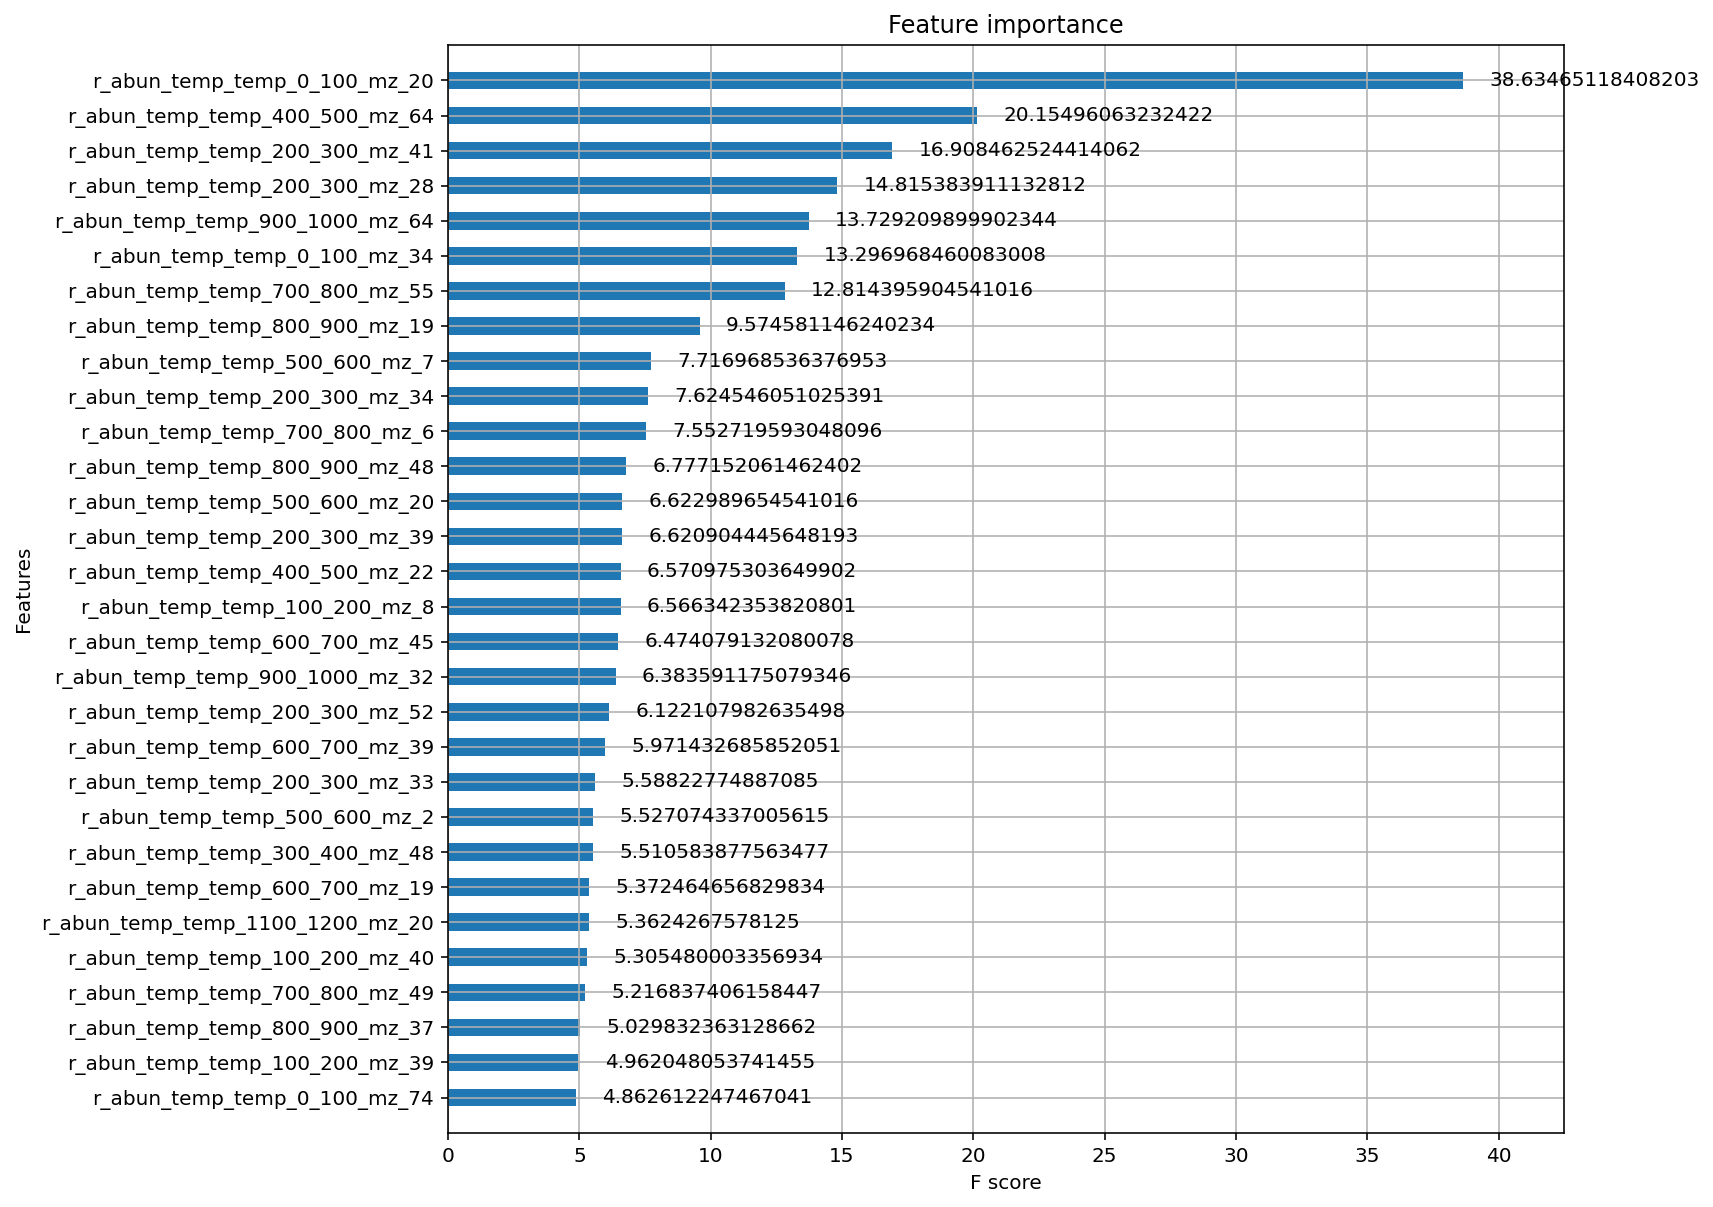

LABEL: carbonate


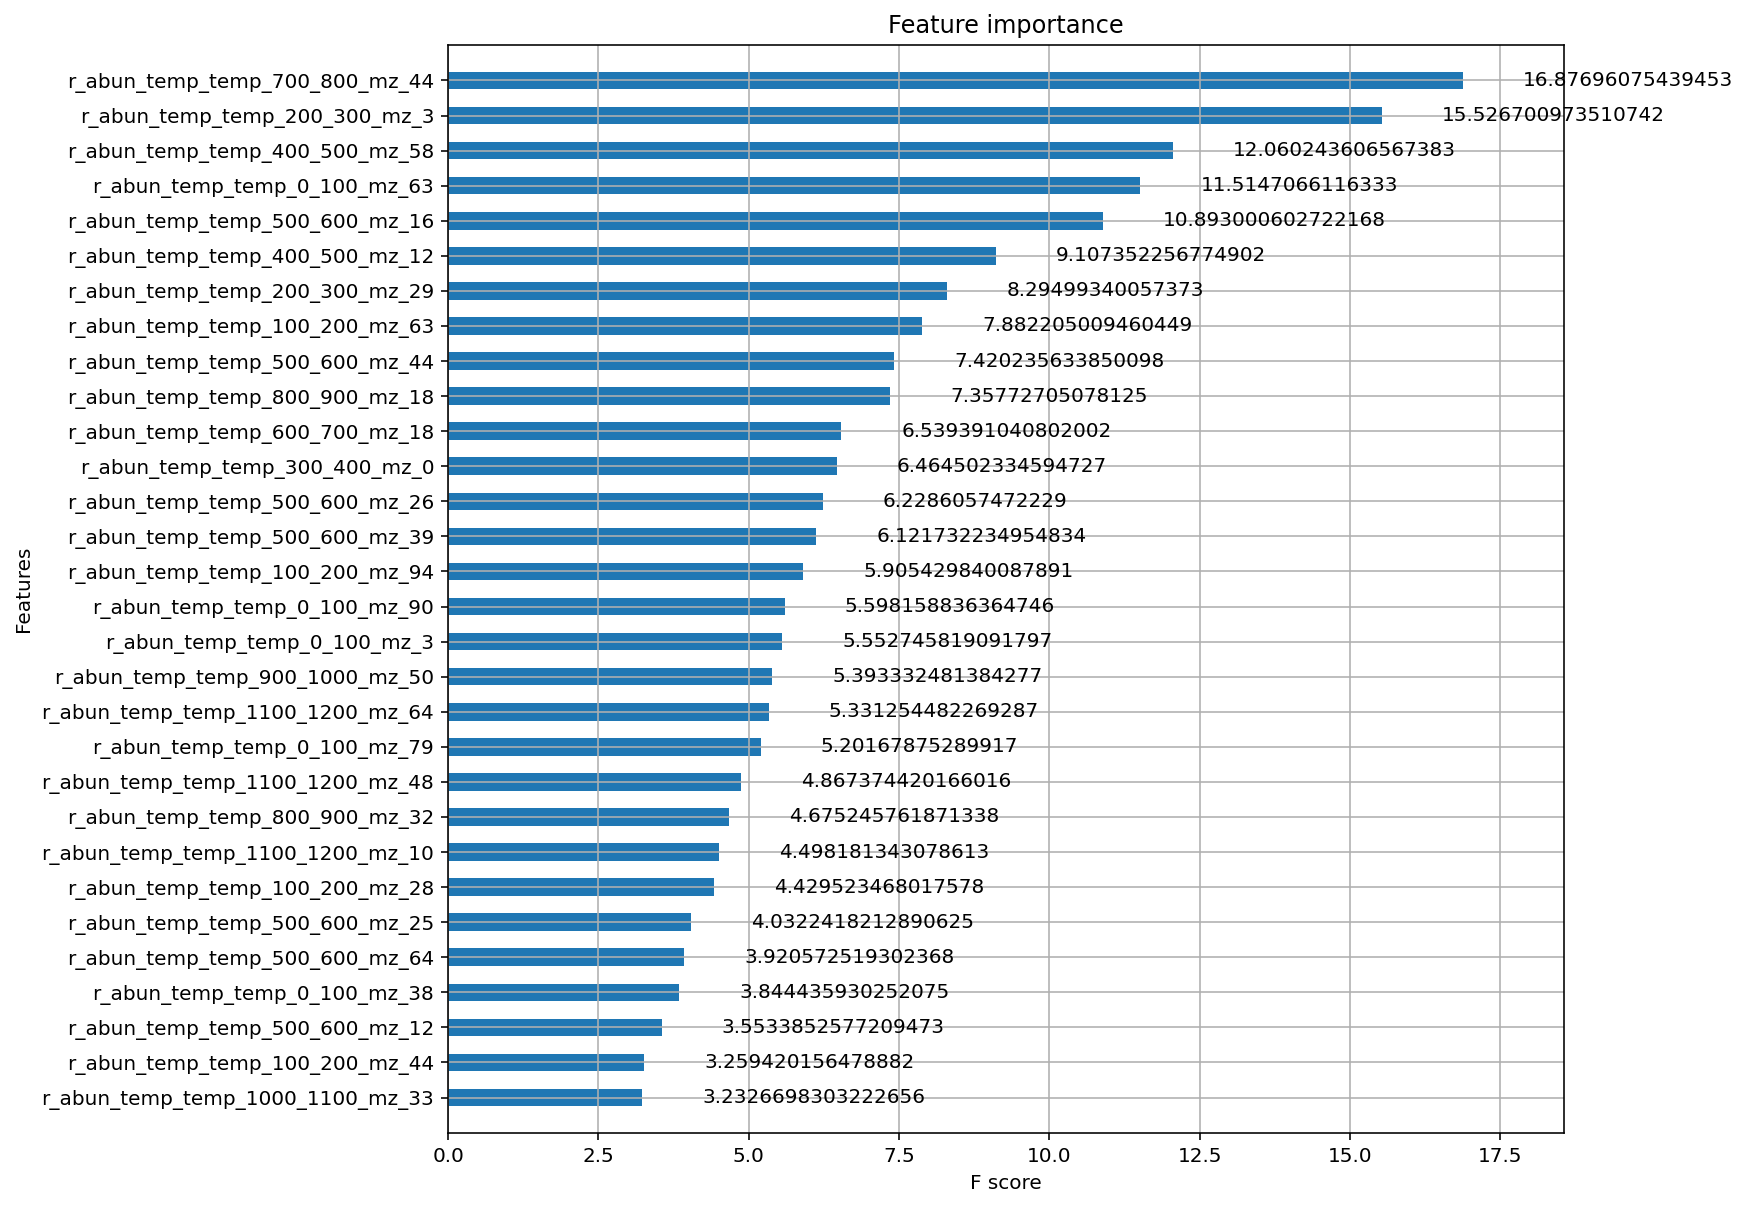

LABEL: chloride


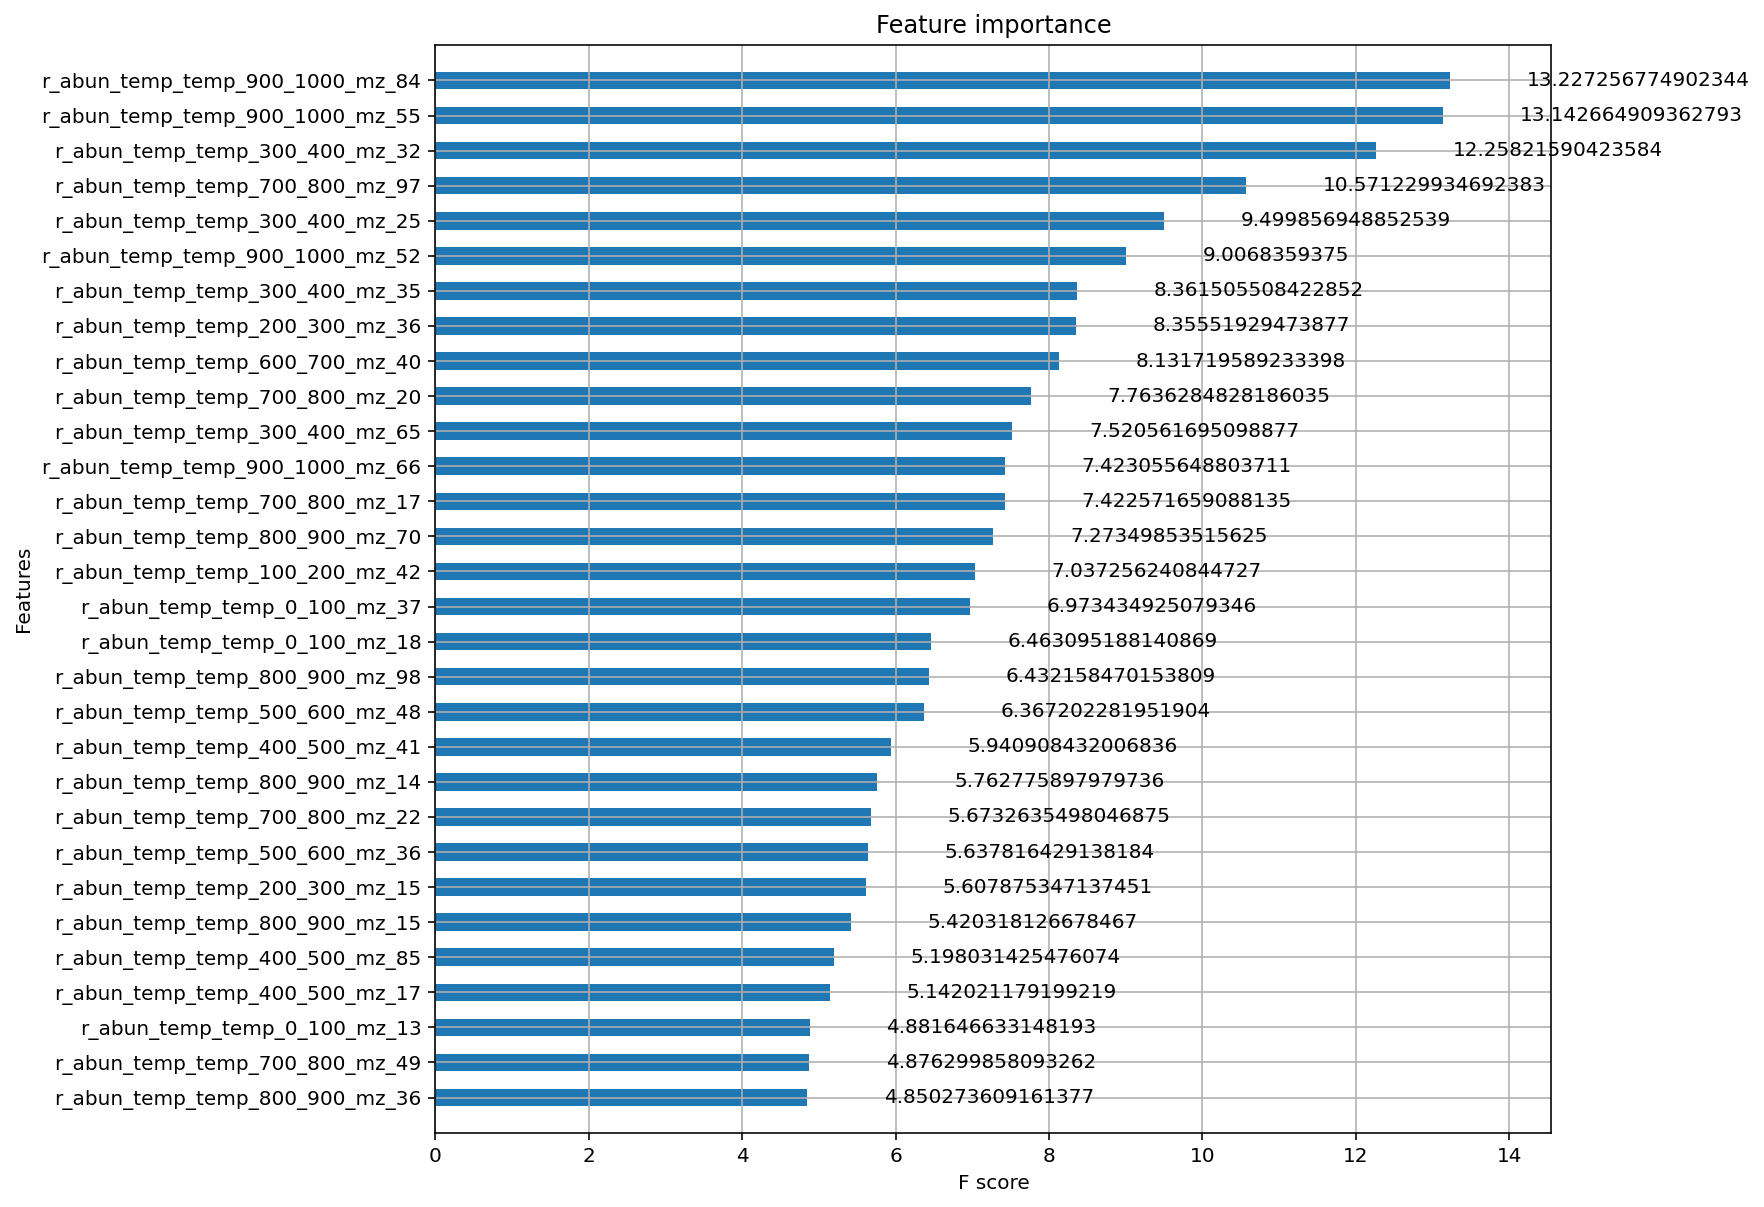

LABEL: iron_oxide


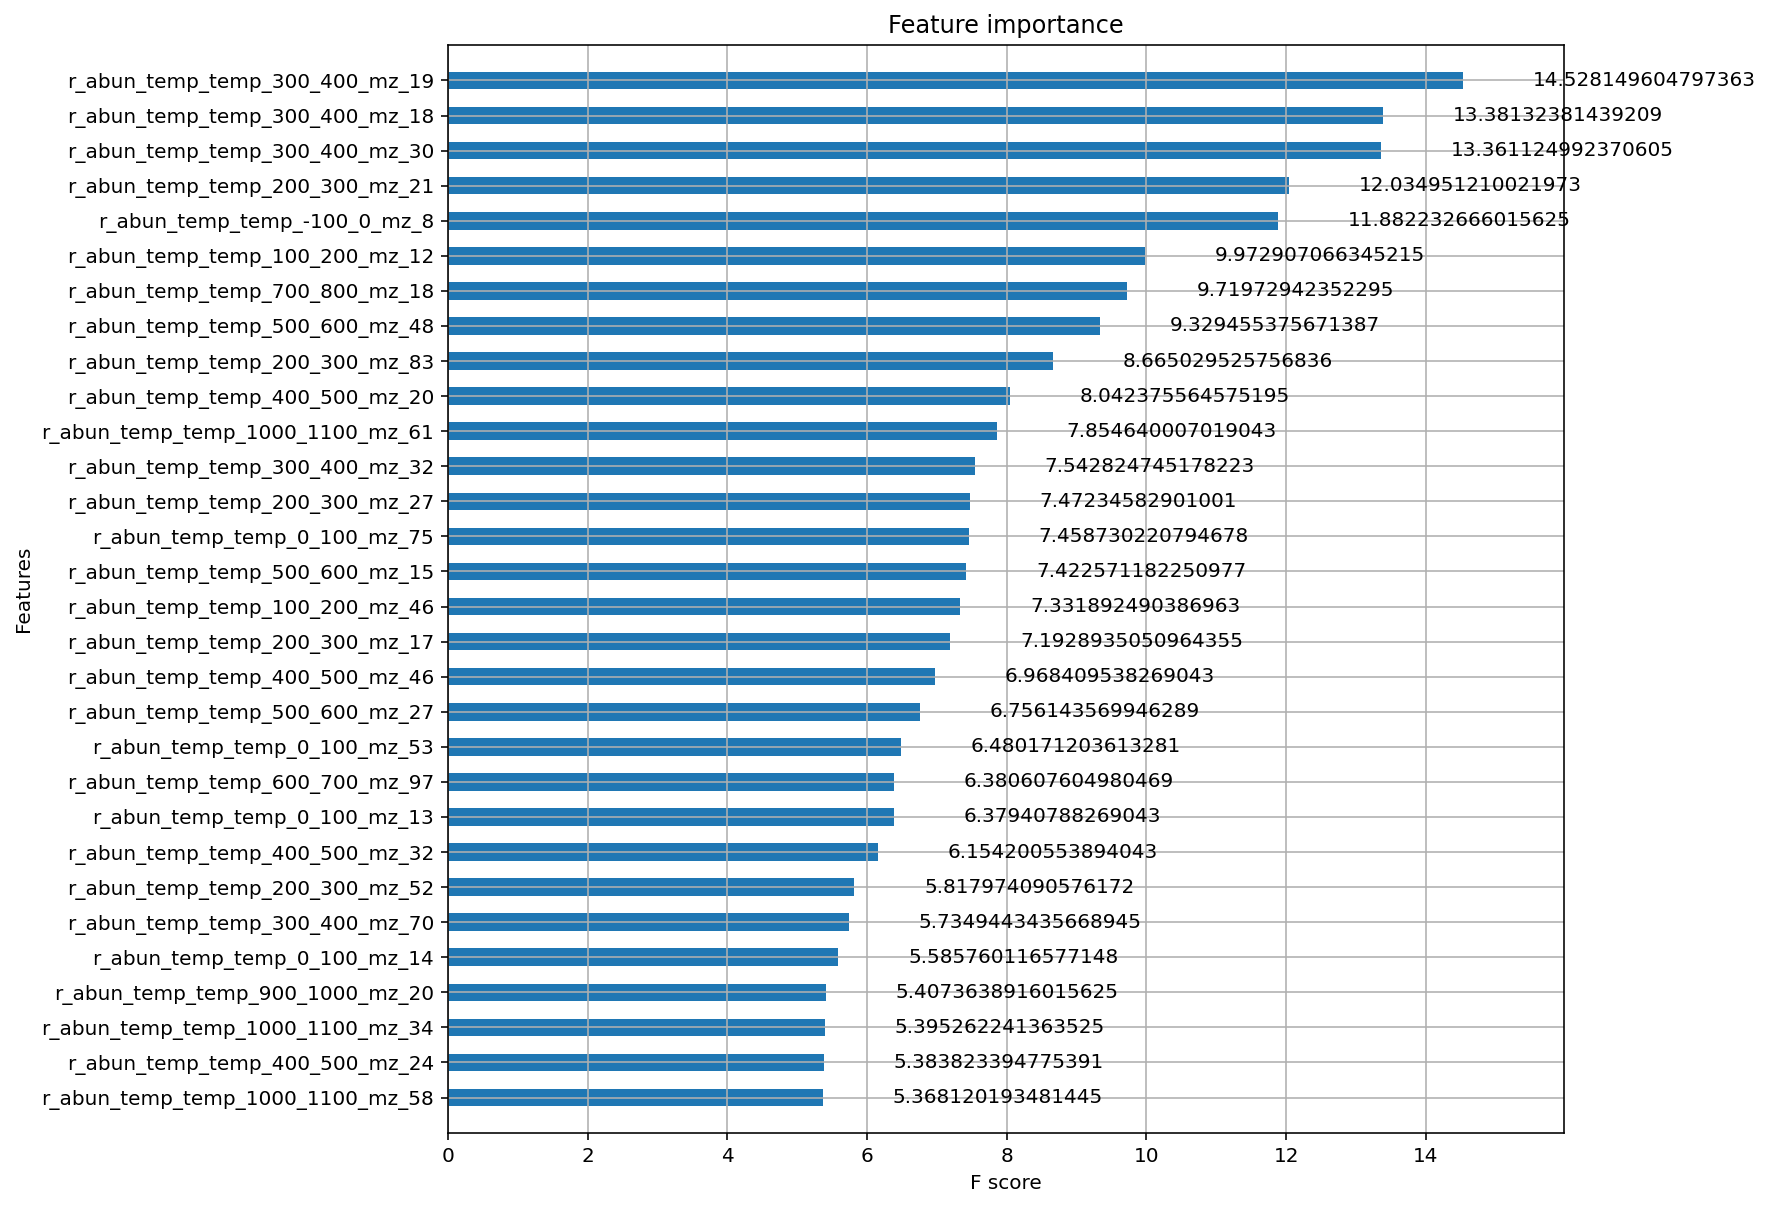

LABEL: oxalate


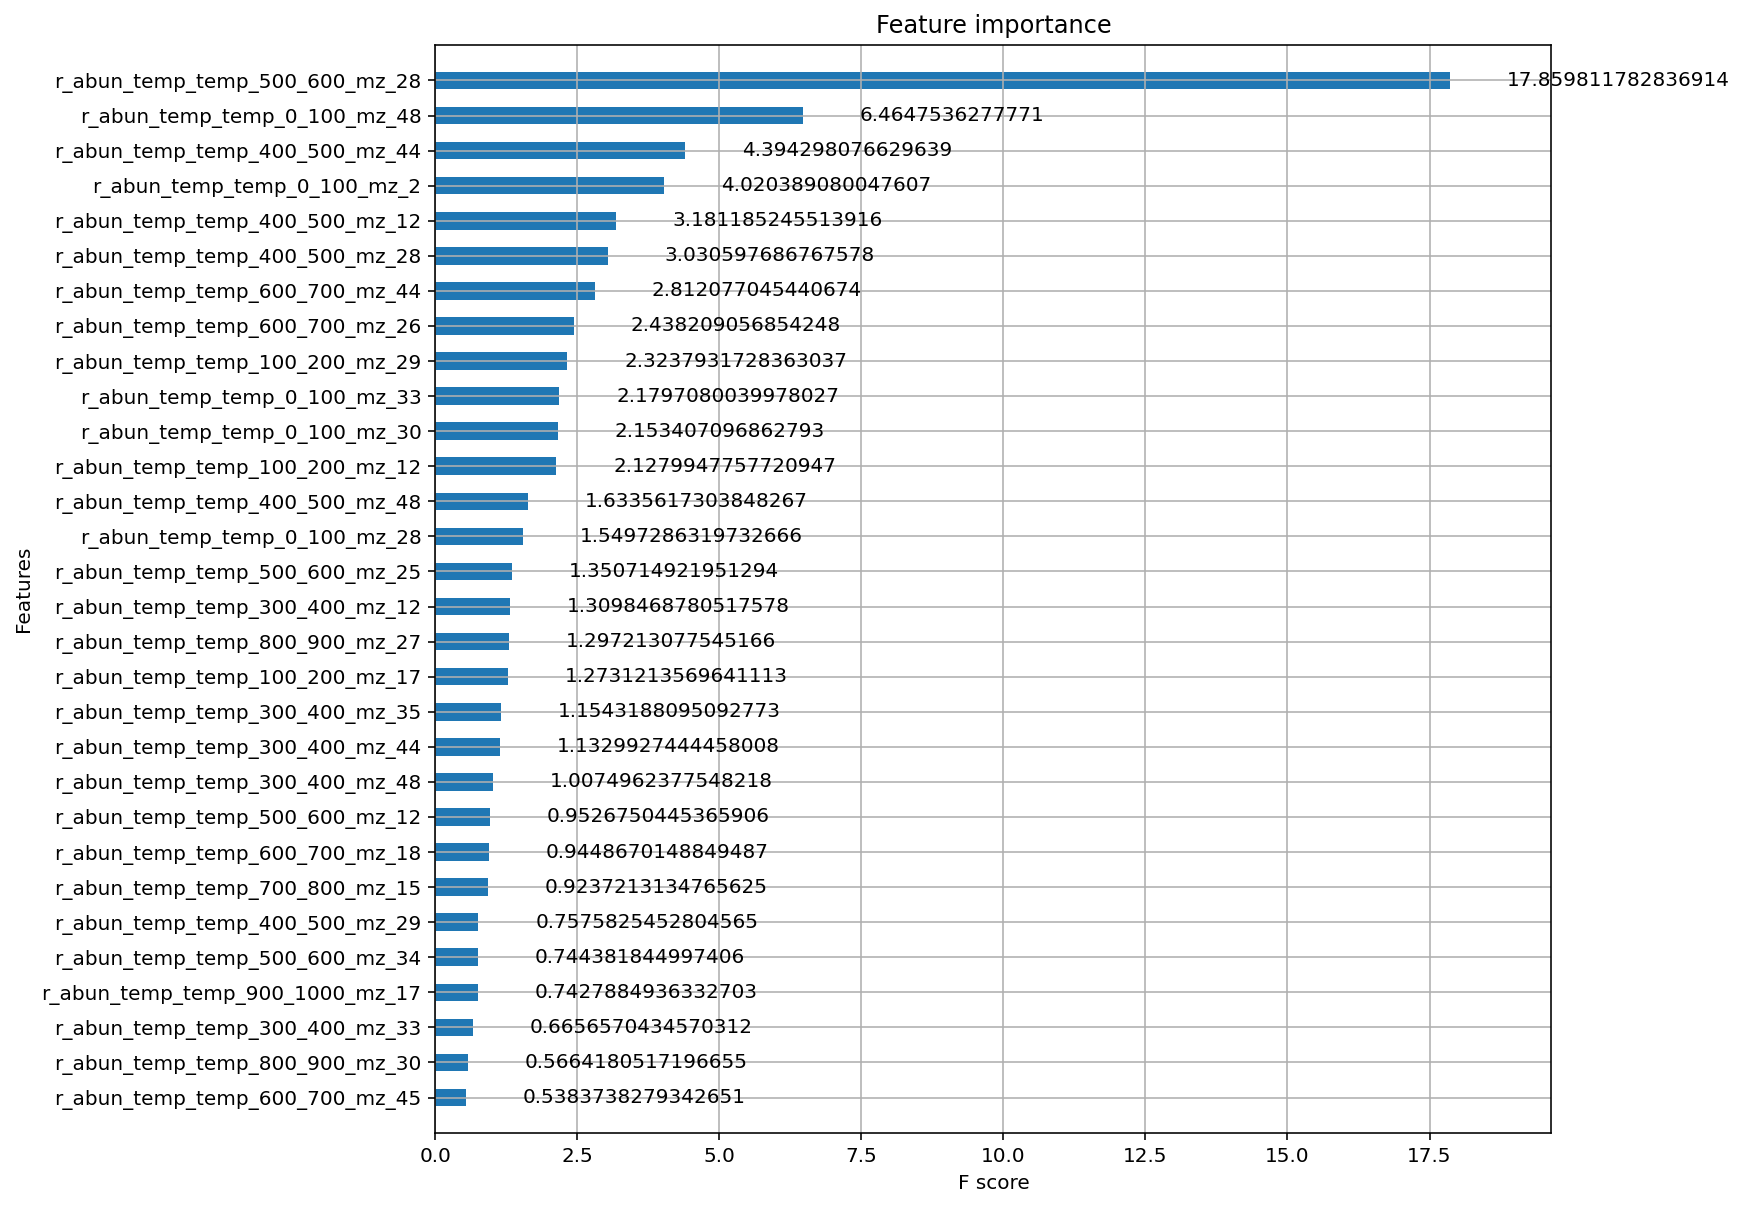

LABEL: oxychlorine


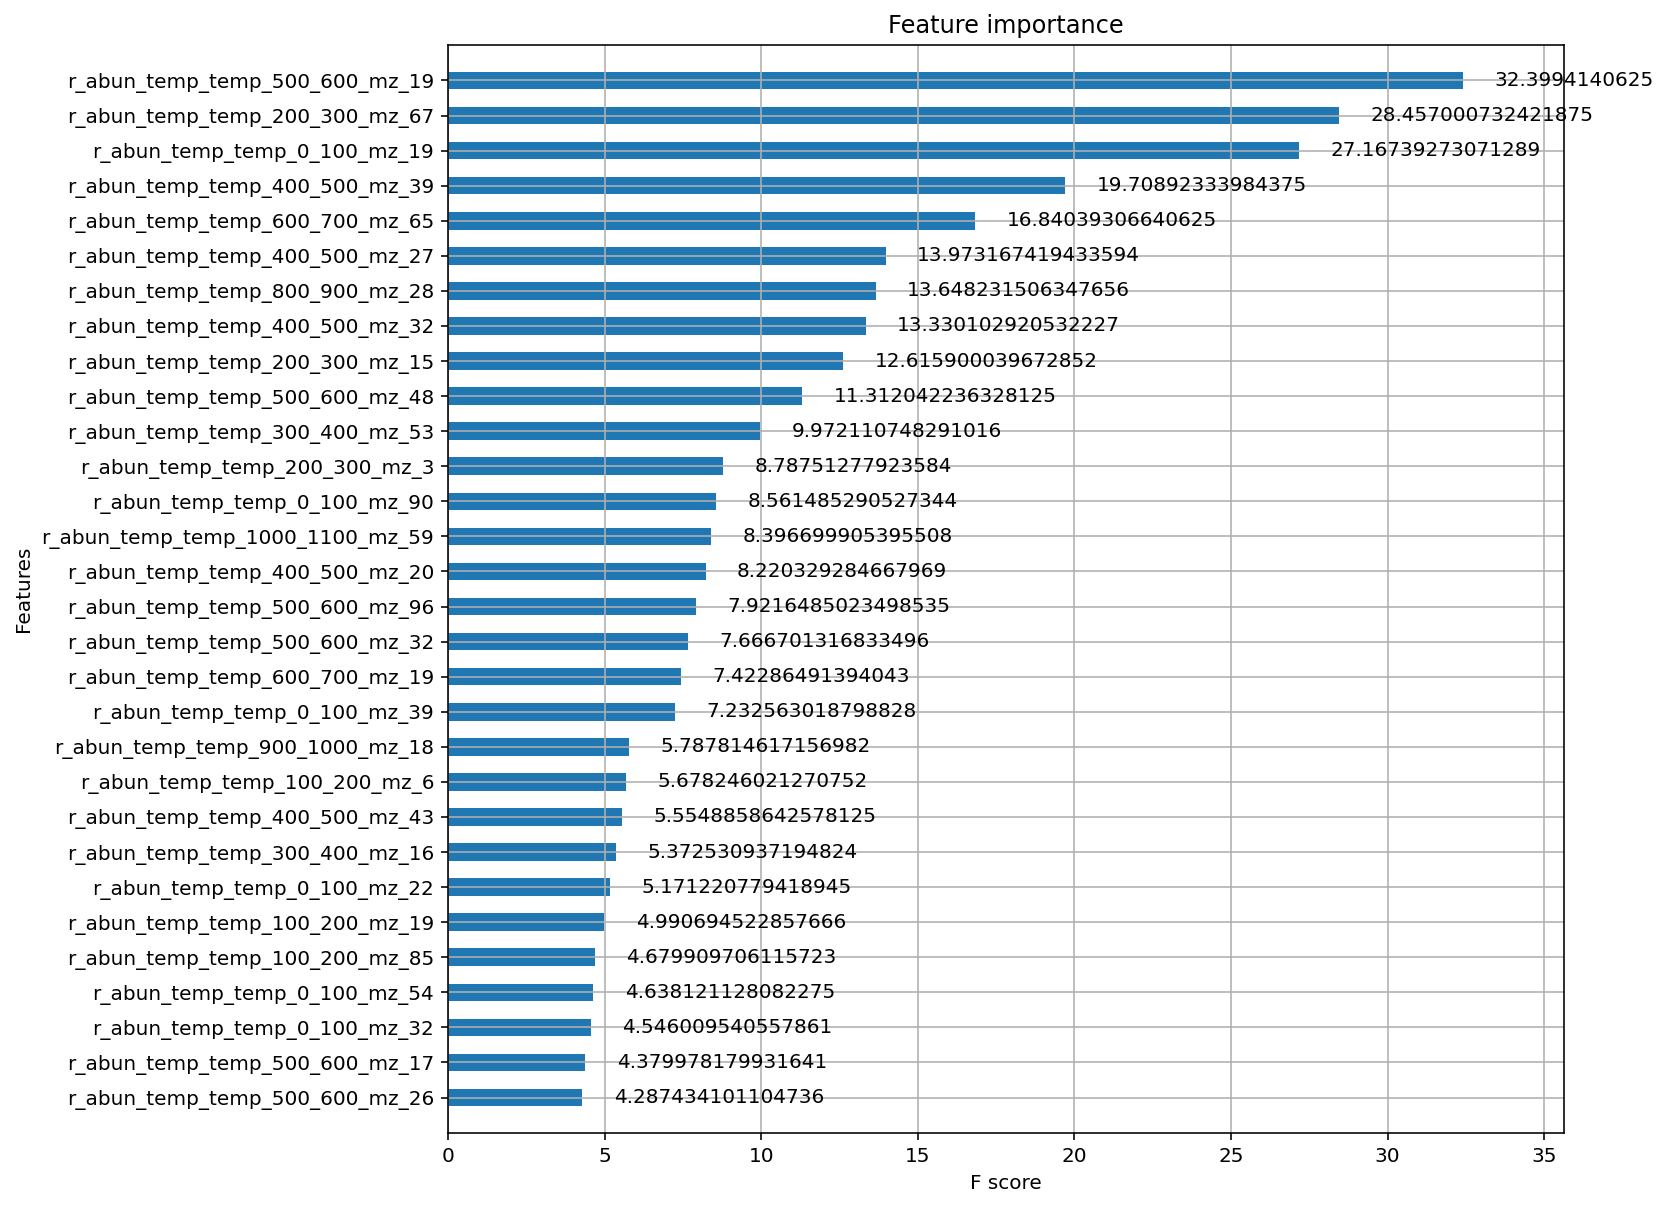

LABEL: phyllosilicate


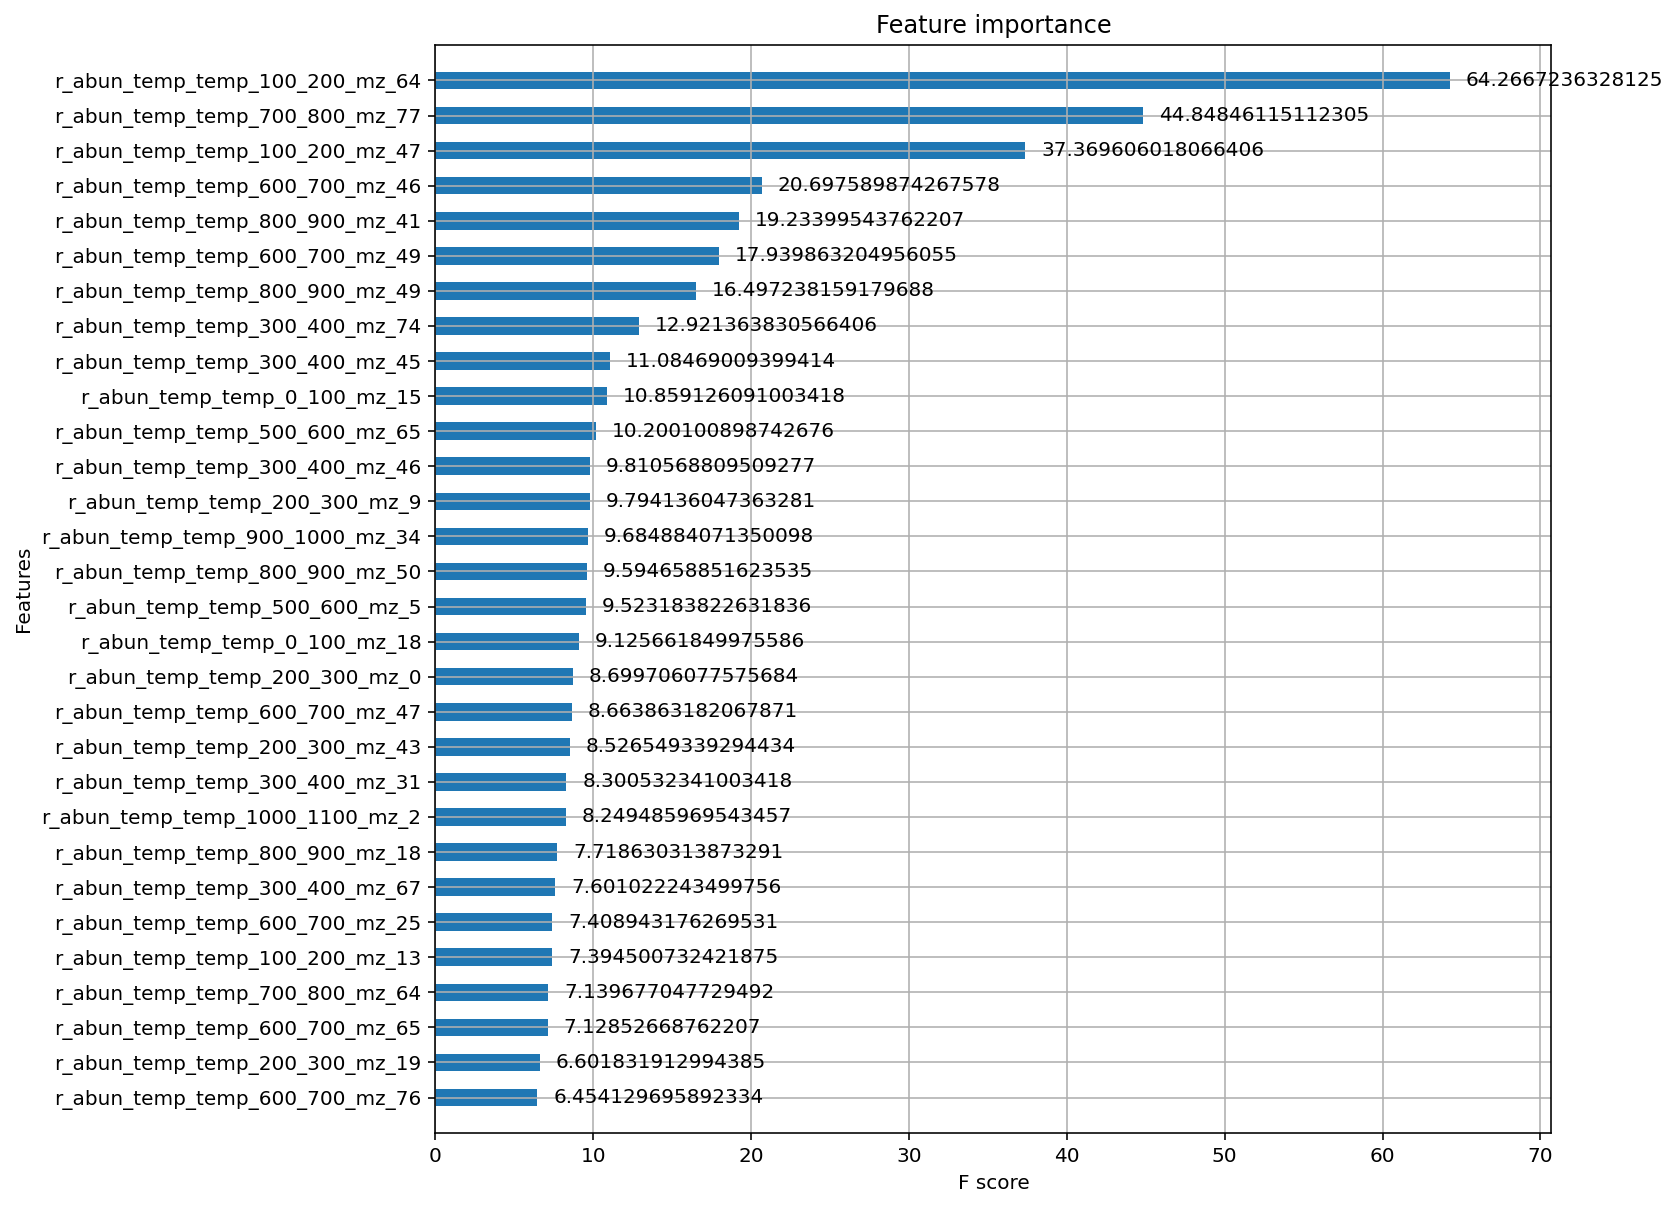

LABEL: silicate


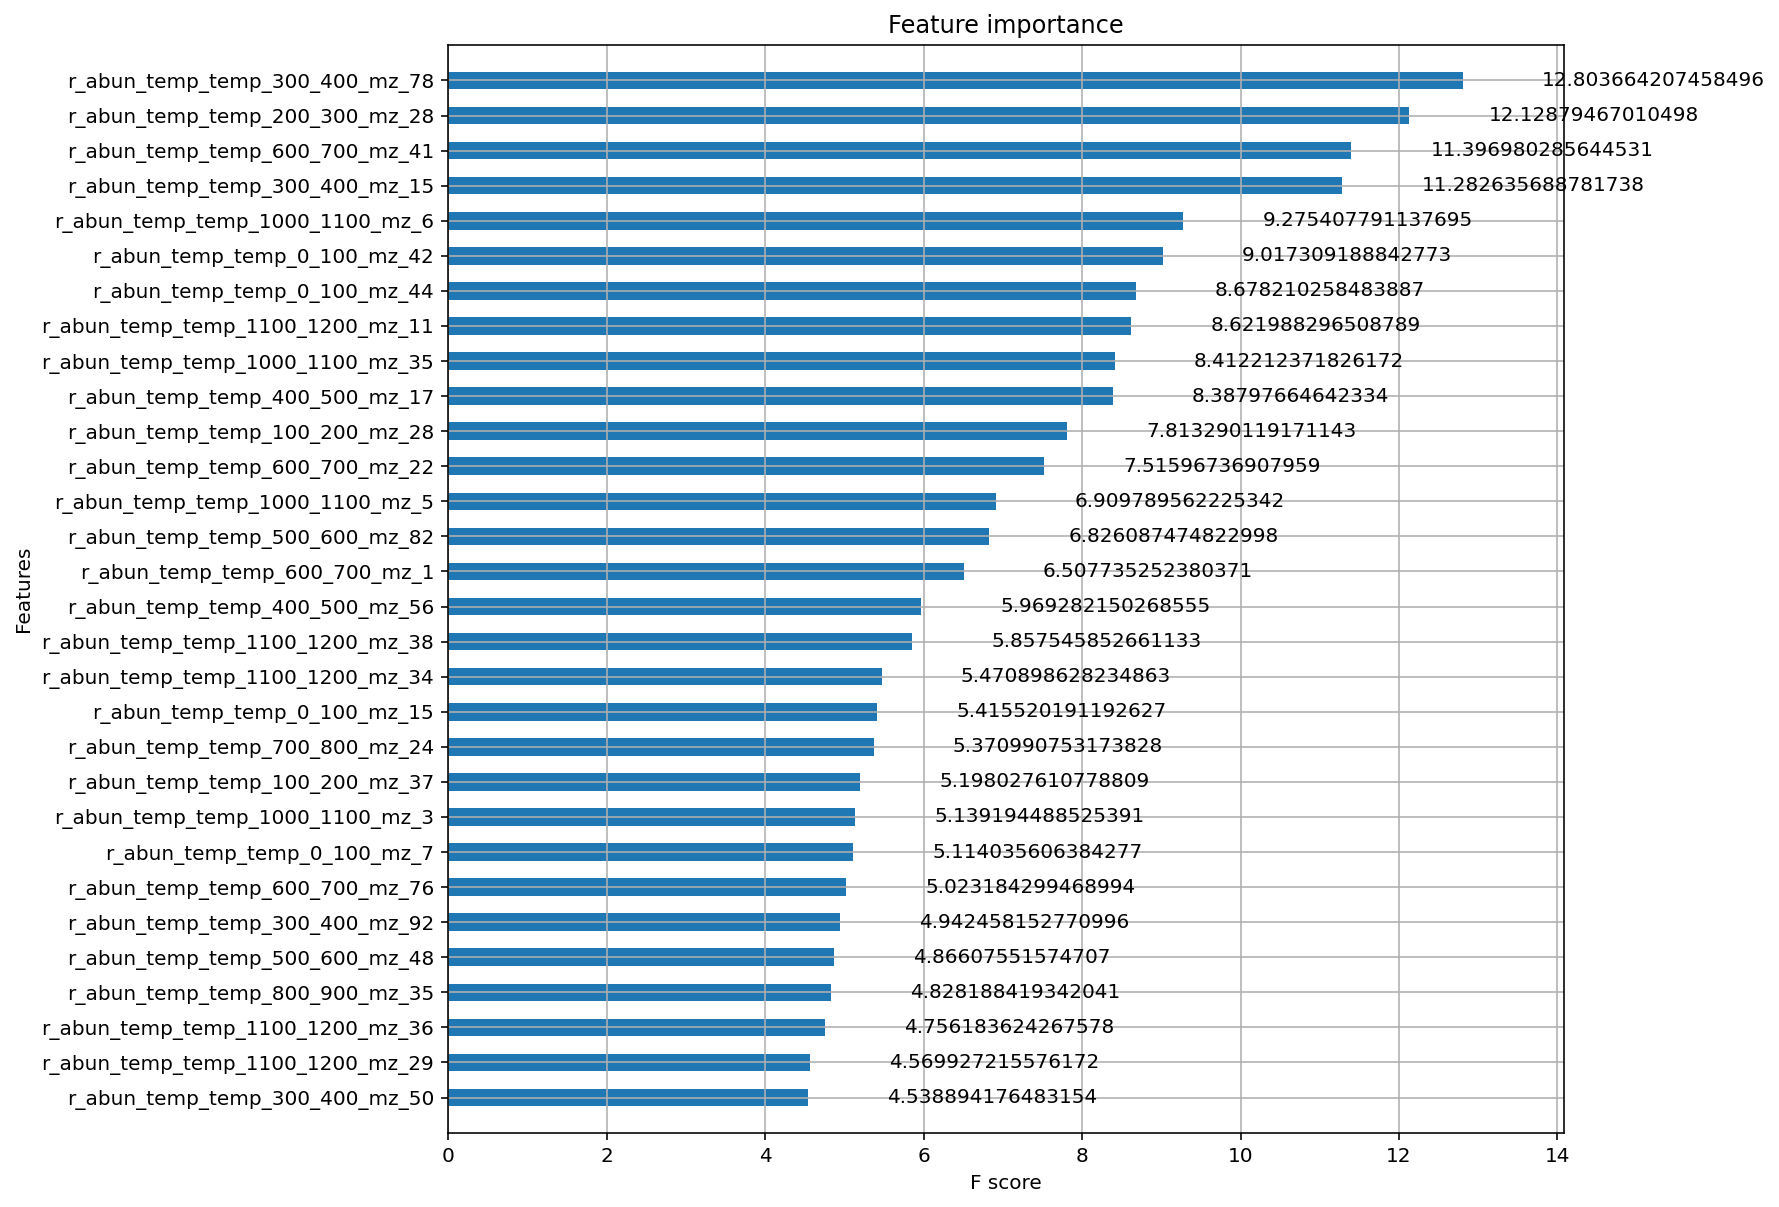

LABEL: sulfate


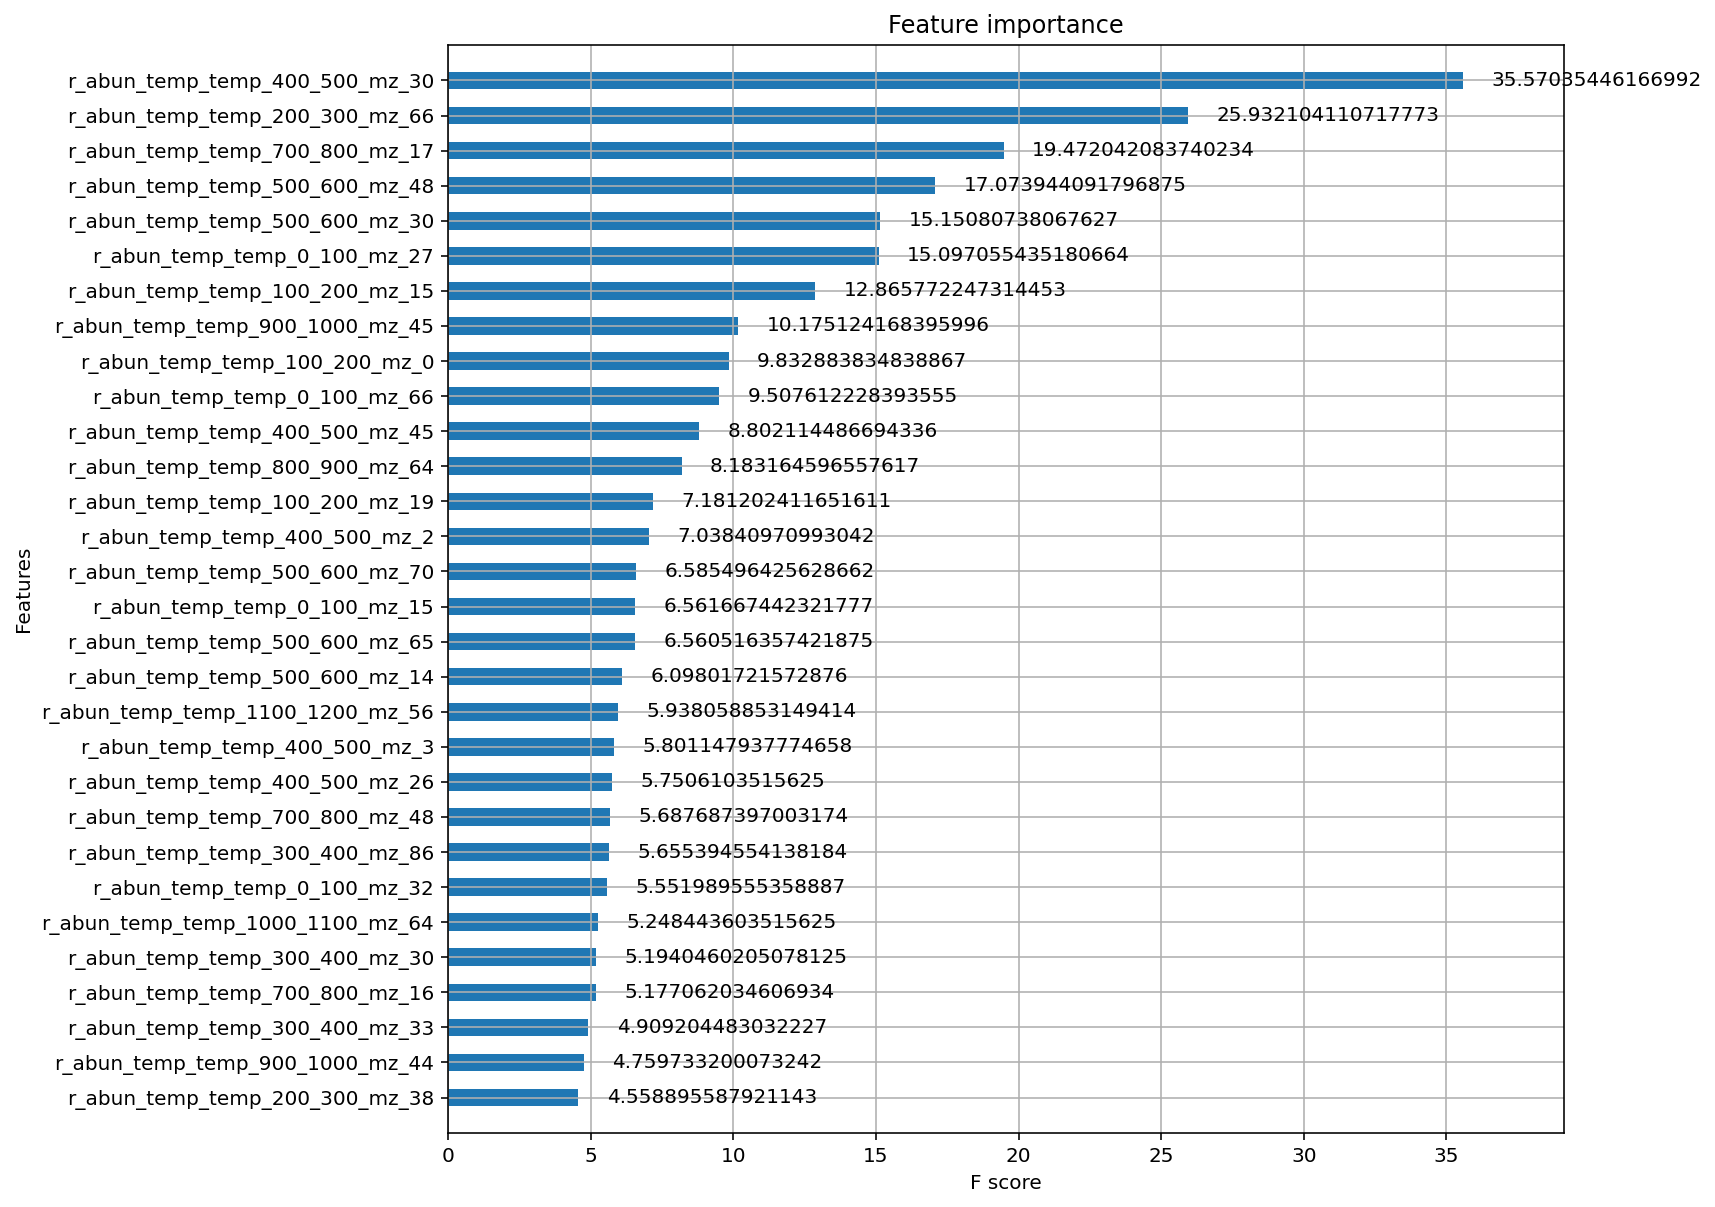

LABEL: sulfide


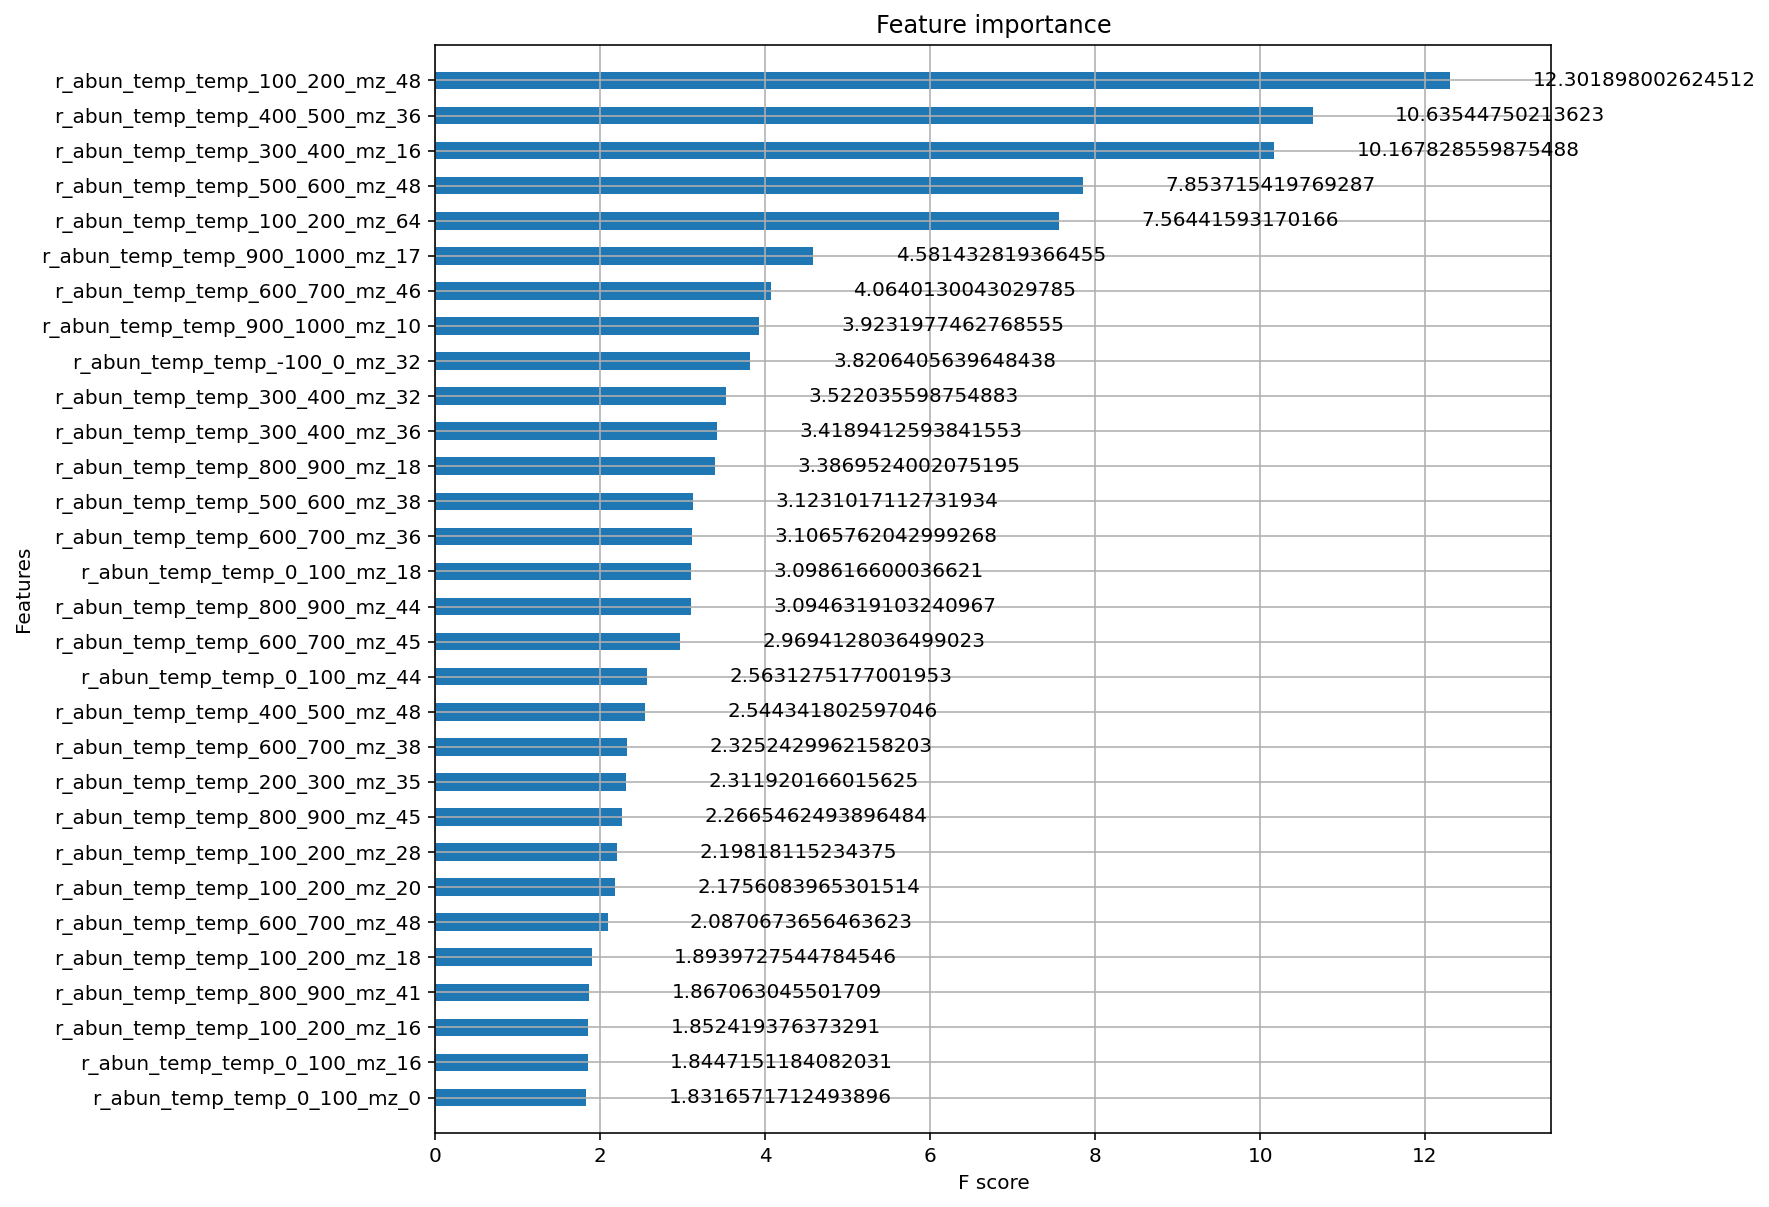


Average Log Loss: 0.1863
Log Loss per Label:
{'basalt': 0.21773357994343634, 'carbonate': 0.13297557350547412, 'chloride': 0.20328190076836977, 'iron_oxide': 0.24859256185105422, 'oxalate': 0.025575726731949168, 'oxychlorine': 0.18790812405290275, 'phyllosilicate': 0.28636247831569356, 'silicate': 0.2524292166081186, 'sulfate': 0.233223894477383, 'sulfide': 0.07489581469864418}
(293, 10)


In [6]:
# ===== TRAIN =====
cvloss, submission_model = training.train_tbl(
    df_train=X_tr,
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test=X_vlte,
    model_algo=MODEL_ALGO,
    sub_name=MODEL_NAME + '_tr'
    )

# Compute validation loss when full model is trained
mloss, mloss_avg = training.compute_valid_loss(submission_model,
                                               valid_files, valid_labels,
                                               target_labels_list,
                                               sub_name=MODEL_NAME + '_tr')

In [7]:
print(f'CV Logloss: {np.mean(list(cvloss.values()))}')
print(f'VALID FM LogLoss: {mloss_avg}')
print(f'CV logLoss Label')
print(cvloss)

CV Logloss: 0.18629788709530257
VALID FM LogLoss: 0.3711651559215064
CV logLoss Label
{'basalt': 0.21773357994343634, 'carbonate': 0.13297557350547412, 'chloride': 0.20328190076836977, 'iron_oxide': 0.24859256185105422, 'oxalate': 0.025575726731949168, 'oxychlorine': 0.18790812405290275, 'phyllosilicate': 0.28636247831569356, 'silicate': 0.2524292166081186, 'sulfate': 0.233223894477383, 'sulfide': 0.07489581469864418}


**TRAIN & VALID**

In [ ]:
# ===== TRAIN =====
cvloss, submission_model = training.train_tbl(
    df_train=X_trvl,
    df_labels=trvl_labels,
    target_list=target_labels_list,
    df_test=X_vlte,
    model_algo=MODEL_ALGO,
    sub_name=MODEL_NAME + '_trvl'
    )

In [ ]:
print(f'CV Logloss: {np.mean(list(cvloss.values()))}')
print(f'CV logLoss Label')
print(cvloss)

**SAM TRAINING**

In [ ]:
# ===== TRAIN SAM =====
cvloss, submission_model = training.train_tbl(
    df_train=X_tr_sam,
    df_labels=sam_labels,
    target_list=target_labels_list,
    df_test=X_vl_sam,
    model_algo=MODEL_ALGO,
    sub_name=MODEL_NAME + '_sam',
    test_sam=True
    )

# Compute validation loss when full model is trained
mloss, mloss_avg = training.compute_valid_loss(submission_model,
                                               sam_files, sam_labels,
                                               target_labels_list,
                                               sub_name=MODEL_NAME + '_sam')

In [ ]:
print(f'CV Logloss: {np.mean(list(cvloss.values()))}')
print(f'VALID FM LogLoss: {mloss_avg}')
print(f'CV logLoss Label')
print(cvloss)